In [139]:
## according to cpuworld opteron 6272 is bulldozer cpu with '16' cores. That means only 8 fpu's and 16 alus represented as 16 cores.
## And the task use fpu. L2 cache is 'shared' per 2 ALU 1 FPU (1 block). L3 is shared. According to cpuworld 2x8mB L3 points to NUMA
## 4 + 4 blocks. The task uses memory much more than calculation (~1024M for 64bit double). So optimal perf is predicted at 4 threads.
## And yes there is definite dip there.

import numpy as np
import subprocess
from mpl_toolkits import mplot3d
%matplotlib widget
plt.style.use('dark_background')
from tabulate import tabulate
import matplotlib.pyplot as plt
from tqdm import tqdm

In [140]:
x_max = 5
t_max = 10
# 3d surface work properly only when x_points == t_points
x_points = 512
t_points = 512
n_proc = 6

plt_rcount = 128
plt_ccount = 128

t_points_at_x_var = 100
x_points_start = n_proc
x_points_end = 25000
x_var_step = 1000

x_points_at_t_var = 100
t_points_start = 10
t_points_end = 25000
t_var_step = 1000

np_start = 1
np_end = 6
t_points_at_np_var = 4096
x_points_at_np_var = 4096

  rank    calc time    gather time    total time
------  -----------  -------------  ------------
     0   0.00277767     0.00243138    0.0912084
     1   0.0027493      0.00108615    0.0038419
     2   0.00269483     0.00137822    0.00438259
     3   0.00276315     0.00168052    0.00444818
     4   0.00279839     0.0019518     0.0050759
     5   0.00274161     0.00226373    0.0050125


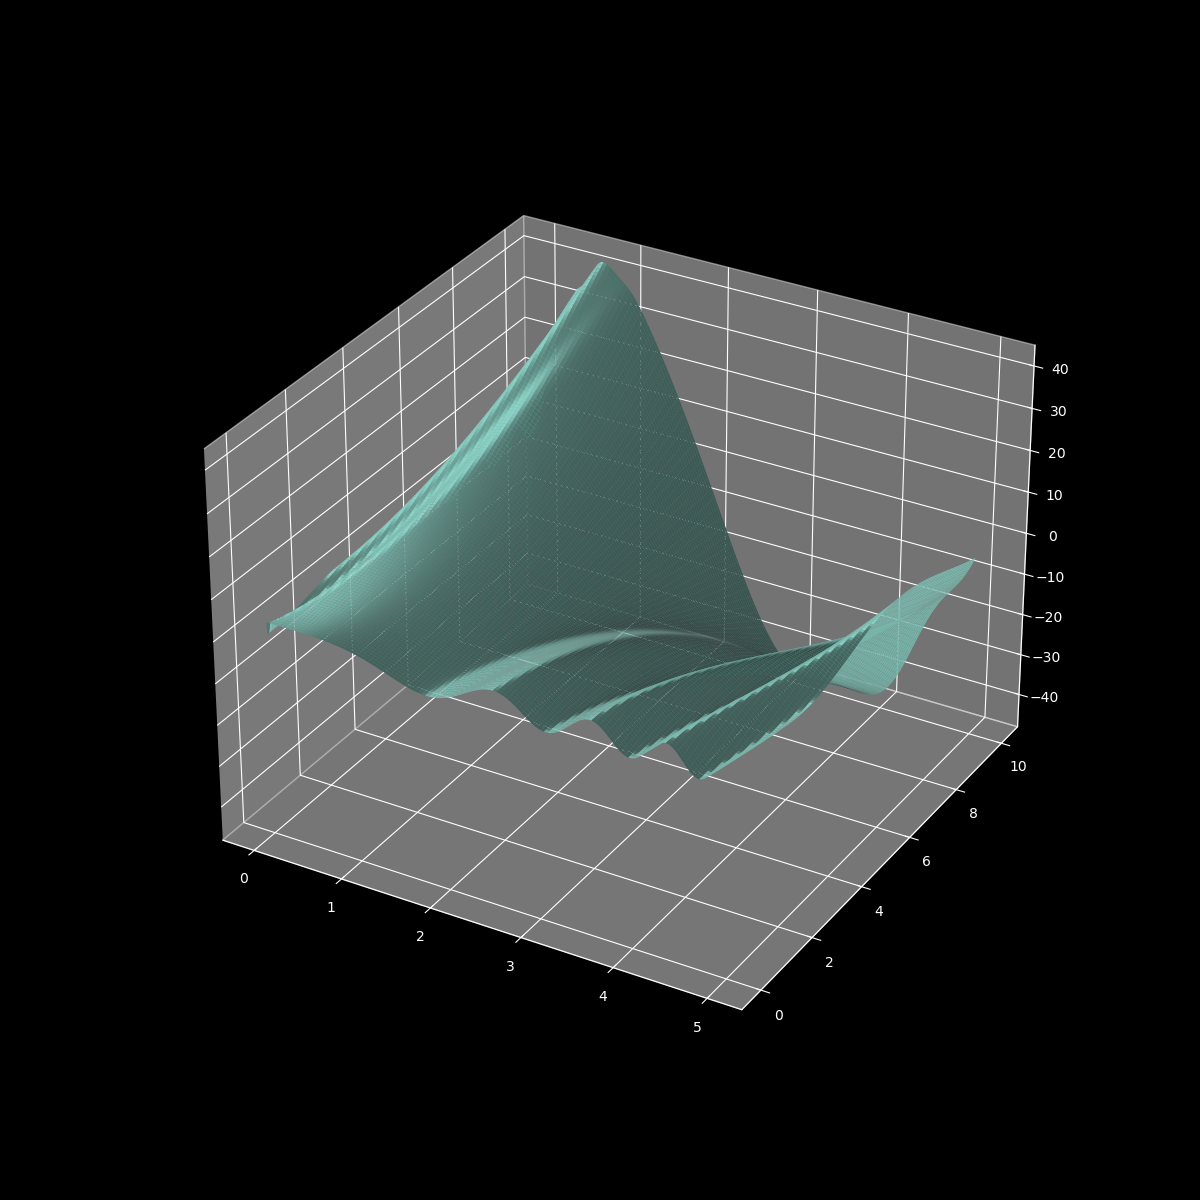

In [141]:
matrix = np.zeros ((x_points, x_points))
perf_ranks = np.zeros ((n_proc, 3))
result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (x_points), "{0}".format (t_points), "{0}".format (x_max), "{0}".format (t_max), "{0}".format (t_points - x_points), "{0}".format (t_points)], capture_output=True, text=True)
res_split = result.stdout.split ()
for i in range (0, x_points):
    for j in range (0, x_points):
        matrix[i][j] = res_split[i * x_points + j]
for i in range (0, n_proc):
    rank = res_split[x_points * x_points + i * 4]
    for j in range (0, 3):
        perf_ranks[int (rank)][j] = res_split[x_points * x_points + i * 4 + j + 1]
#print ("last layer :")
#print (matrix[x_points - 1])

tabledata = []
for i in range (0, n_proc):
    temp = []
    temp.append (i)
    temp.append (perf_ranks[i][0])
    temp.append (perf_ranks[i][1])
    temp.append (perf_ranks[i][2])
    tabledata.append (temp)
print (tabulate (tabledata, headers = ["rank", "calc time", "gather time", "total time"]))

X = np.outer (np.linspace (0, x_max, x_points), np.ones (x_points)).copy().T
T = np.outer (np.linspace (0, t_max, x_points), np.ones (x_points))
plt.figure(figsize=(12, 12))
plt.axes(projection ='3d').plot_surface (X, T, matrix, rcount = plt_rcount, ccount = plt_ccount)

100%|██████████| 25/25 [00:03<00:00,  7.64it/s]

  x_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
         6      0.000263584        0.000136765       0.000300555
      1006      0.000884931        0.00106298        0.00176769
      2006      0.00150577         0.00191033        0.00325835
      3006      0.00299923         0.00269549        0.00460282
      4006      0.00284184         0.00343602        0.00592353
      5006      0.00360118         0.00390772        0.00570659
      6006      0.00434406         0.00521965        0.00887032
      7006      0.00476401         0.00504264        0.00926074
      8006      0.00566036         0.00652378        0.0114051
      9006      0.00601193         0.00651225        0.00991454
     10006      0.00664361         0.00746945        0.0133816
     11006      0.0073037          0.00762475        0.0141829
     12006      0.00868896         0.00776415        0.0148589
     13006      0.00888757         0.0083

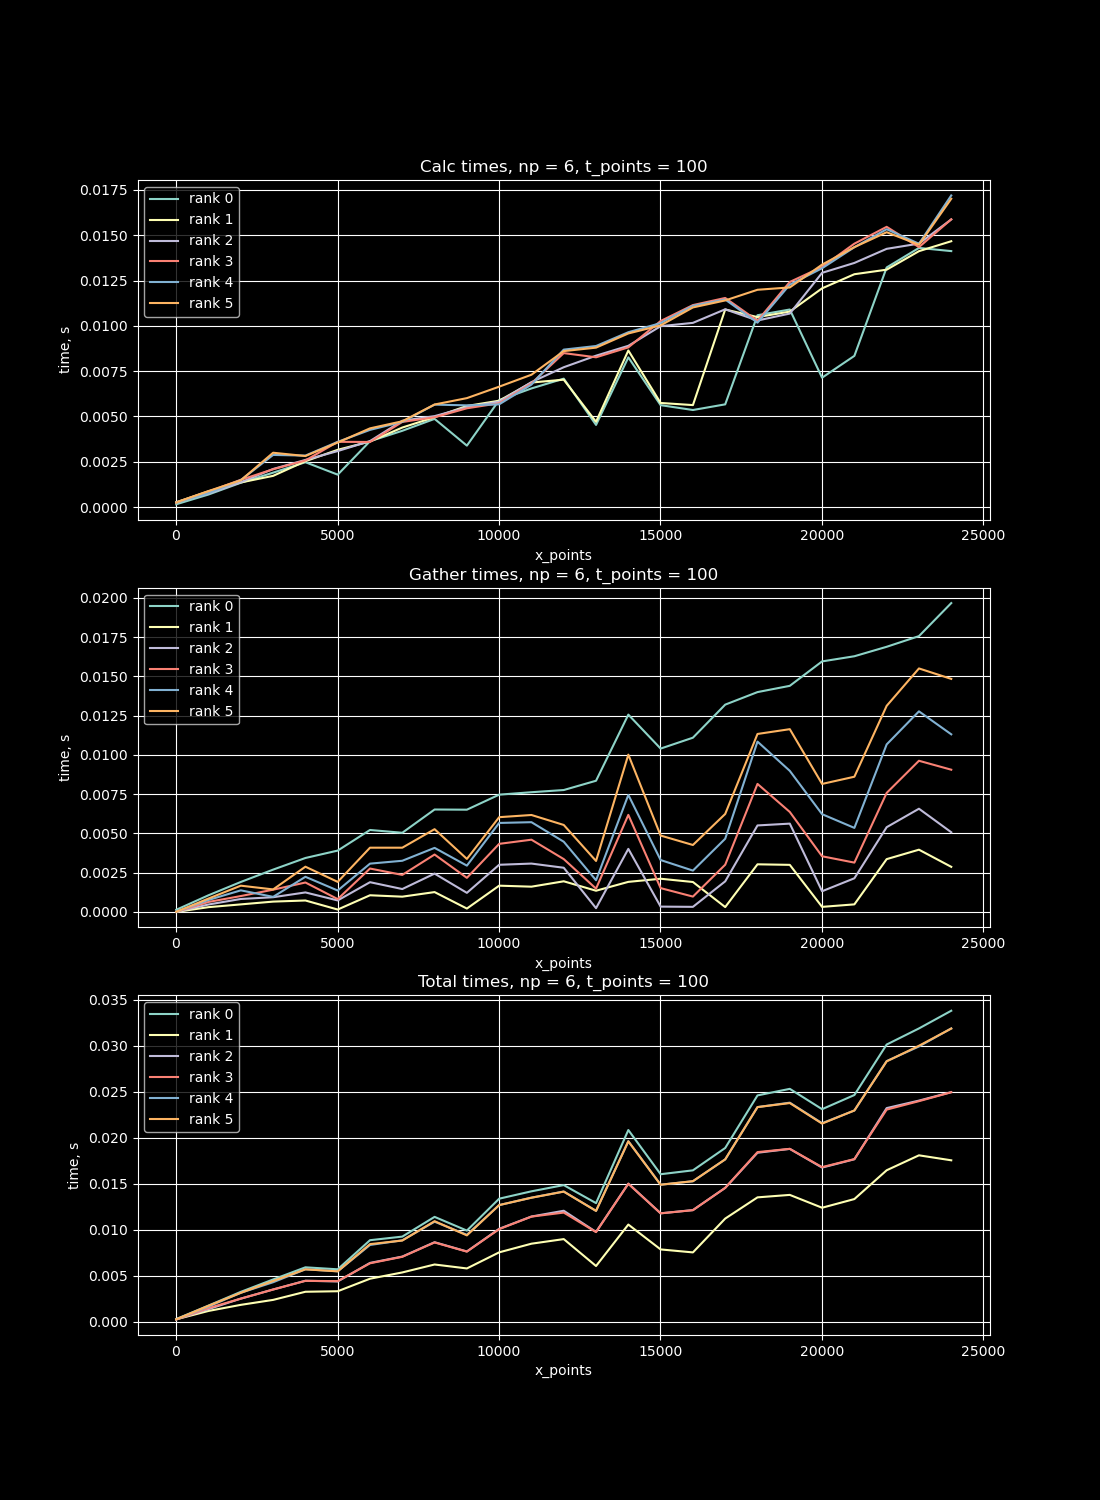

In [142]:
### x_points var at host
x_points_var = np.zeros (int ((x_points_end - x_points_start) / x_var_step) + 1)
times = np.zeros ((3, n_proc, int ((x_points_end - x_points_start) / x_var_step) + 1))
i = x_points_start
k = 0
tabledata = []
with tqdm(total=int ((x_points_end - x_points_start) / x_var_step) + 1) as pbar:
    while i < x_points_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (i), "{0}".format (t_points_at_x_var), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        x_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + x_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["x_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 25/25 [00:04<00:00,  6.25it/s]


  t_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
        10      0.000142526        4.583e-05          0.0001522
      1010      0.0025634          0.000908808        0.00339882
      2010      0.00674358         0.00252149         0.00931163
      3010      0.00804766         0.00259447         0.00952815
      4010      0.00901695         0.0032868          0.0109356
      5010      0.0120374          0.00410775         0.0138246
      6010      0.0123891          0.00610824         0.016852
      7010      0.0142904          0.00771374         0.0167215
      8010      0.0158604          0.00856952         0.0183662
      9010      0.0217322          0.0115995          0.0253081
     10010      0.0209985          0.00876315         0.0246609
     11010      0.0253299          0.0116244          0.0299182
     12010      0.0262179          0.0138012          0.0303763
     13010      0.0262601          0

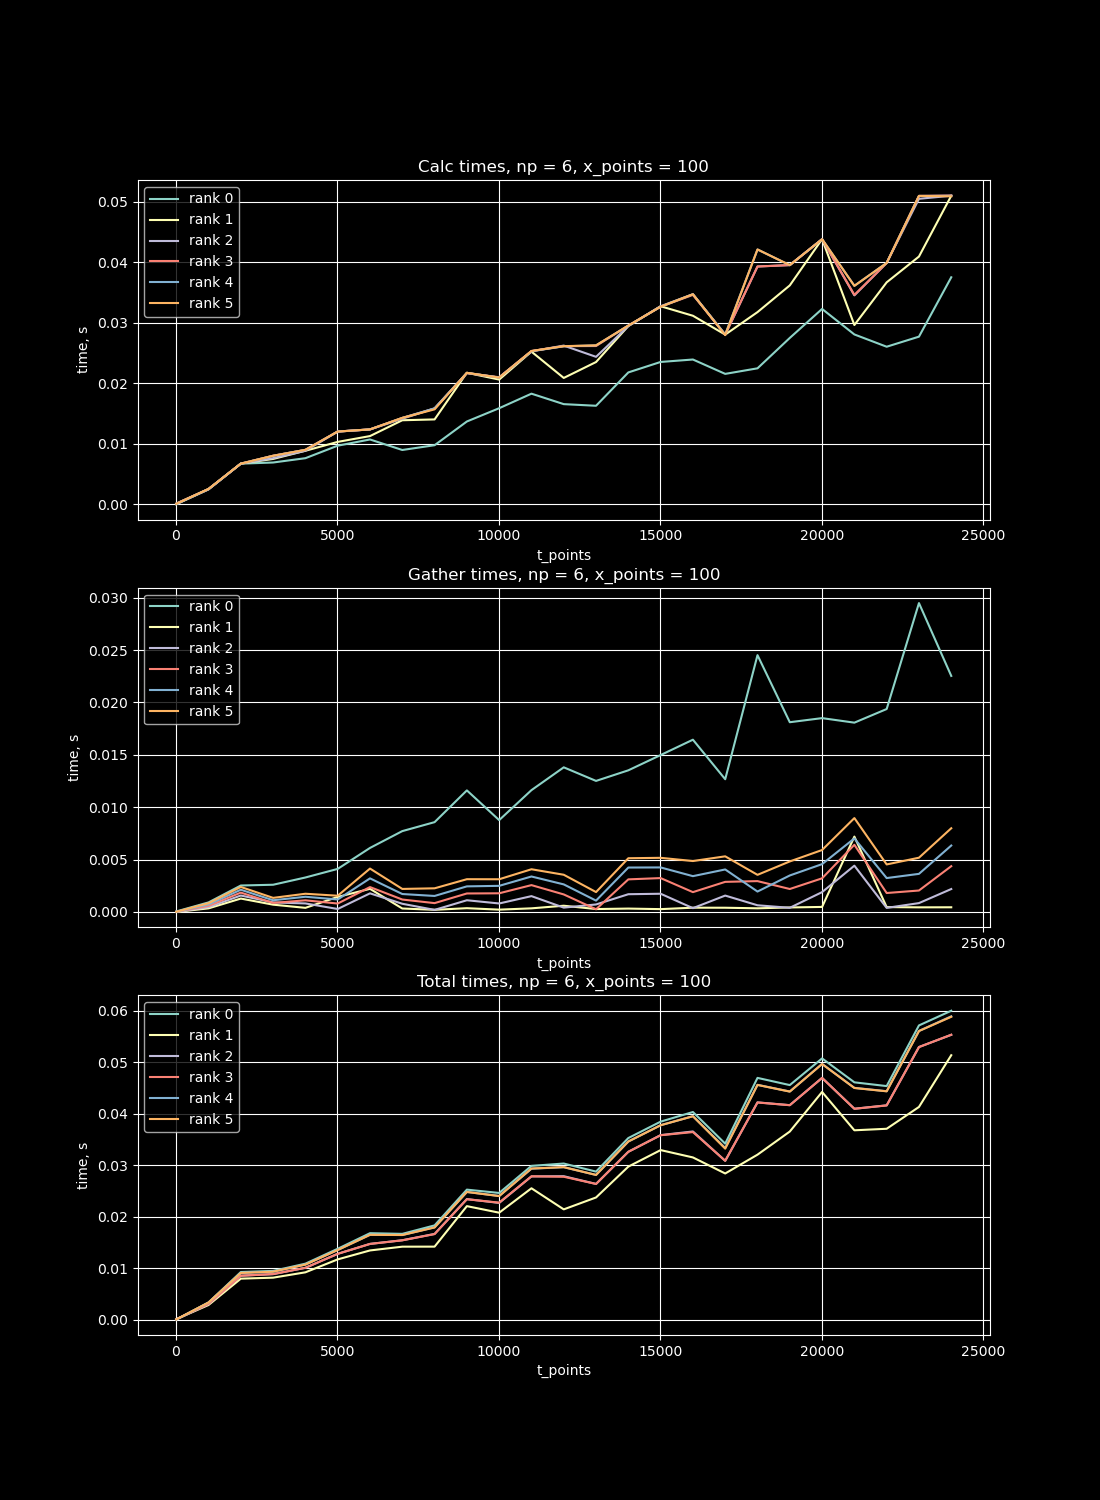

In [143]:
### t_points var at host
t_points_var = np.zeros (int ((t_points_end - t_points_start) / t_var_step) + 1)
times = np.zeros ((3, n_proc, int ((t_points_end - t_points_start) / t_var_step) + 1))
i = t_points_start
k = 0
tabledata = []
with tqdm (total = int ((t_points_end - t_points_start) / t_var_step) + 1) as pbar:
    while i < t_points_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (n_proc), "./transfer", "{0}".format (x_points_at_t_var), "{0}".format (i), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        t_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + t_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["t_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

  N proc    max calc time    max gather time    max total time
--------  ---------------  -----------------  ----------------
       1         0.403514           3.9e-08           0.40354
       2         0.21057            0.103962          0.300832
       3         0.145622           0.108248          0.231838
       4         0.138104           0.103328          0.195889
       5         0.105445           0.106727          0.181003
       6         0.122632           0.106206          0.187671


<StemContainer object of 3 artists>

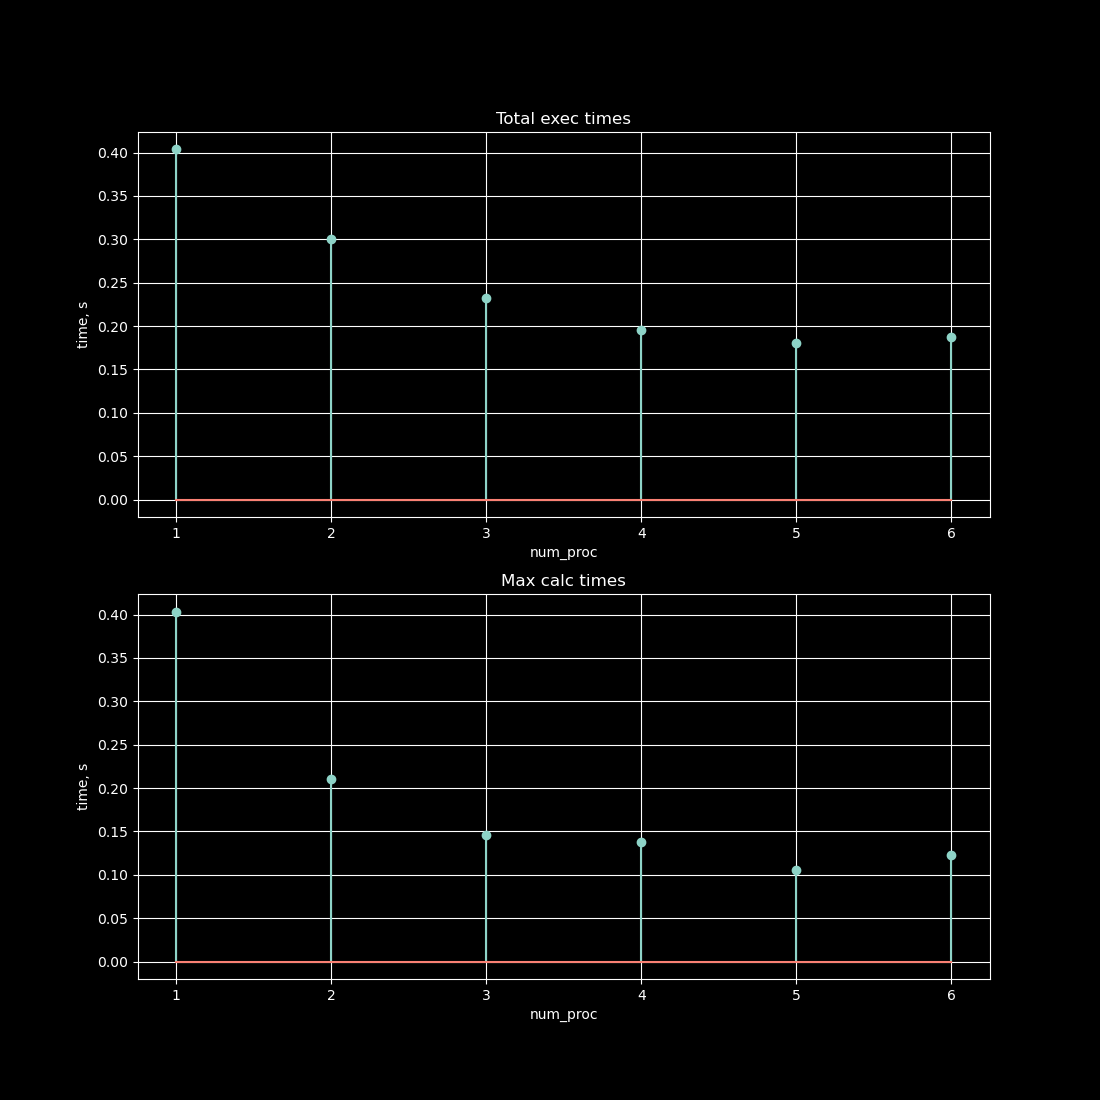

In [144]:
### np var at host

np_var = np.arange (np_start, np_end + 1)
times = np.zeros ((3, np_end - np_start + 1))
i = np_start
tabledata = []
with tqdm (total = np_end - np_start + 1) as pbar:
    while i <= np_end:
        result = subprocess.run (["mpirun", "-np", "{0}".format (i), "./transfer", "{0}".format (x_points_at_np_var), "{0}".format (t_points_at_np_var), "{0}".format (x_max), "{0}".format (t_max), "n"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        max_calc = 0
        max_gather = 0
        max_total = 0
        for p in range (0, i - np_start + 1):
            if float (res_split[p * 4 + 1]) > max_calc:
                max_calc = float (res_split[p * 4 + 1])
            if float (res_split[p * 4 + 2]) > max_gather:
                max_gather = float (res_split[p * 4 + 2])
            if float (res_split[p * 4 + 3]) > max_total:
                max_total = float (res_split[p * 4 + 3])

        times[0][i - np_start] = max_calc
        times[1][i - np_start] = max_gather
        times[2][i - np_start] = max_total
        temp = []
        temp.append (i)
        temp.append (max_calc)
        temp.append (max_gather)
        temp.append (max_total)
        tabledata.append (temp)
        i = i + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["N proc", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 11])

plt.subplot (211)
plt.grid ()
plt.title ("Total exec times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[2])

plt.subplot (212)
plt.grid ()
plt.title ("Max calc times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[0])

make: Entering directory `/home/b0190302/lab1'
mpic++ "-std=c++11"  -o Lab1  main.cpp 
echo -e "\043PBS -l "walltime=00:01:00" \n\043PBS -N Lab1 \n\043PBS -q batch \ncd \044PBS_O_WORKDIR \nmpirun --hostfile \044PBS_NODEFILE "-np 4"  ./Lab1 512 512 5 10 0 512"	> job.sh 
make: Leaving directory `/home/b0190302/lab1'
make: Entering directory `/home/b0190302/lab1'
qsub -o stdout.txt ./job.sh 
152889.head.vdi.mipt.ru
make: Leaving directory `/home/b0190302/lab1'
  rank    calc time    gather time    total time
------  -----------  -------------  ------------
     0   0.00712609     0.0054729      0.311475
     1   0.00890279     0.001194       0.0101192
     2   0.00946307     0.00123715     0.01072
     3   0.00944901     0.00222993     0.0116942


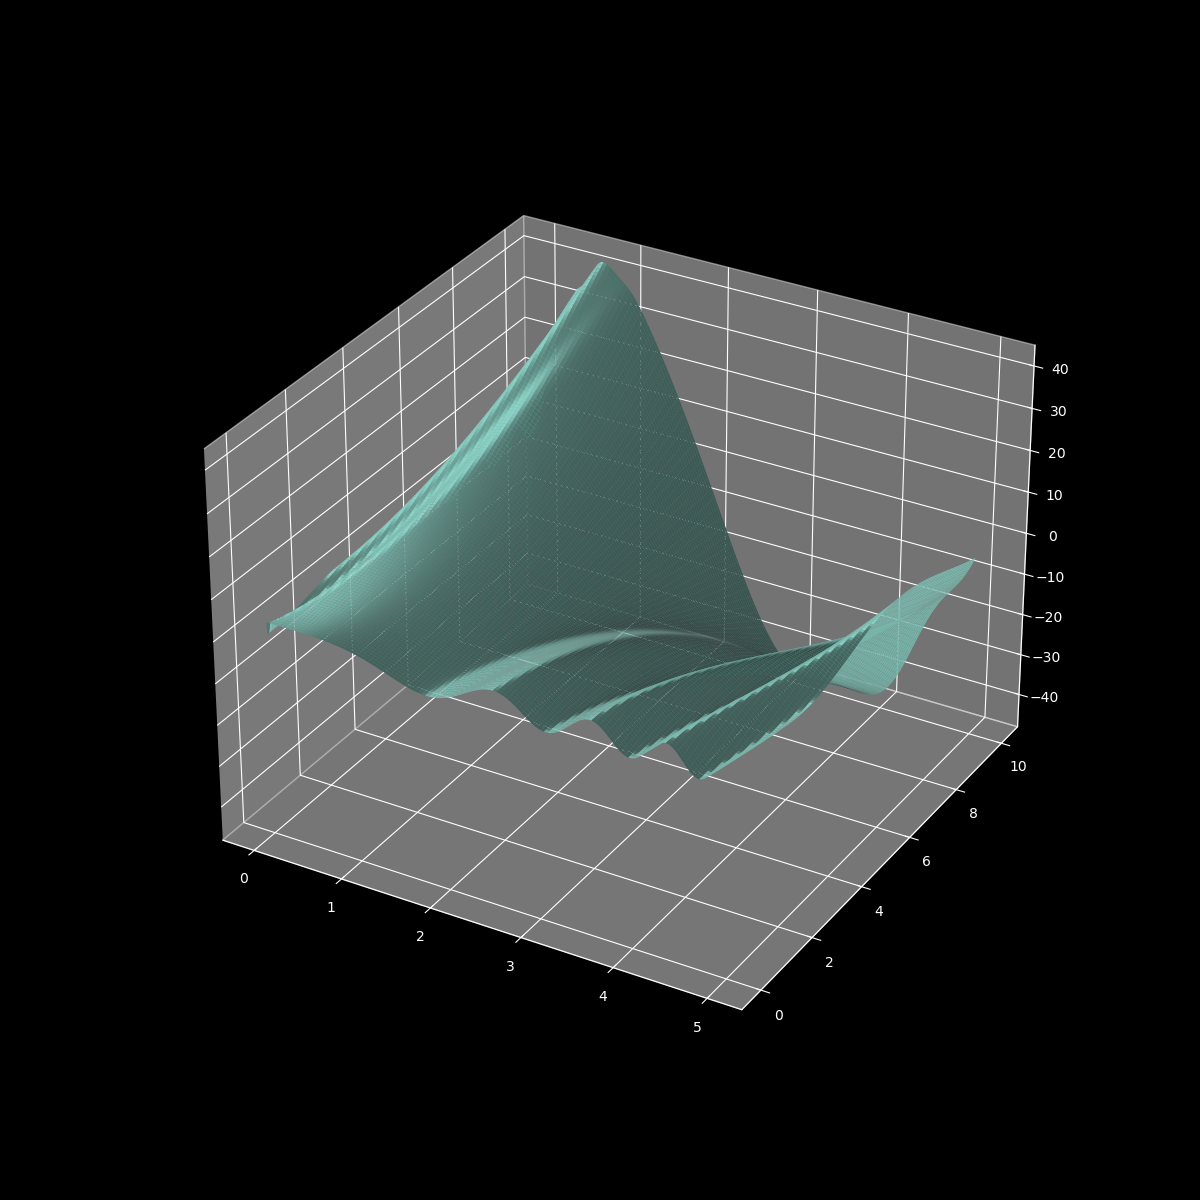

In [145]:
#### CLUSTER through ssh ####
import time
n_proc = 4
np_start = 1
np_end = 32

matrix = np.zeros ((x_points, x_points))
perf_ranks = np.zeros ((n_proc, 3))
compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (x_points), "{0}".format (t_points), "{0}".format (x_max), "{0}".format (t_max), "{0}".format (t_points - x_points), "{0}\"".format (t_points) , "-C", "./lab1/"])
#print (compile)
time.sleep (2)
run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"])
time.sleep (2)
result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
res_split = result.stdout.split ()
for i in range (0, x_points):
    for j in range (0, x_points):
        matrix[i][j] = res_split[i * x_points + j]
for i in range (0, n_proc):
    rank = res_split[x_points * x_points + i * 4]
    for j in range (0, 3):
        perf_ranks[int (rank)][j] = res_split[x_points * x_points + i * 4 + j + 1]
#print ("last layer :")
#print (matrix[x_points - 1])

tabledata = []
for i in range (0, n_proc):
    temp = []
    temp.append (i)
    temp.append (perf_ranks[i][0])
    temp.append (perf_ranks[i][1])
    temp.append (perf_ranks[i][2])
    tabledata.append (temp)
print (tabulate (tabledata, headers = ["rank", "calc time", "gather time", "total time"]))

X = np.outer (np.linspace (0, x_max, x_points), np.ones (x_points)).copy().T
T = np.outer (np.linspace (0, t_max, x_points), np.ones (x_points))
plt.figure(figsize=(12, 12))
plt.axes(projection ='3d').plot_surface (X, T, matrix, rcount = plt_rcount, ccount = plt_ccount)

100%|██████████| 25/25 [02:42<00:00,  6.52s/it]

  x_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
         6      0.000479221        0.000447035       0.000646114
      1006      0.00412416         0.0024941         0.00531101
      2006      0.00762391         0.00452805        0.00997806
      3006      0.0108049          0.00606918        0.014158
      4006      0.015008           0.00821209        0.018816
      5006      0.0197029          0.0116248         0.0249991
      6006      0.0233331          0.0147781         0.0306208
      7006      0.02299            0.014976          0.0334241
      8006      0.0248959          0.0159321         0.0370381
      9006      0.032975           0.01807           0.0427339
     10006      0.032531           0.021462          0.0474539
     11006      0.03952            0.0276549         0.0532491
     12006      0.0390968          0.02509           0.0566289
     13006      0.0472541          0.0273299     

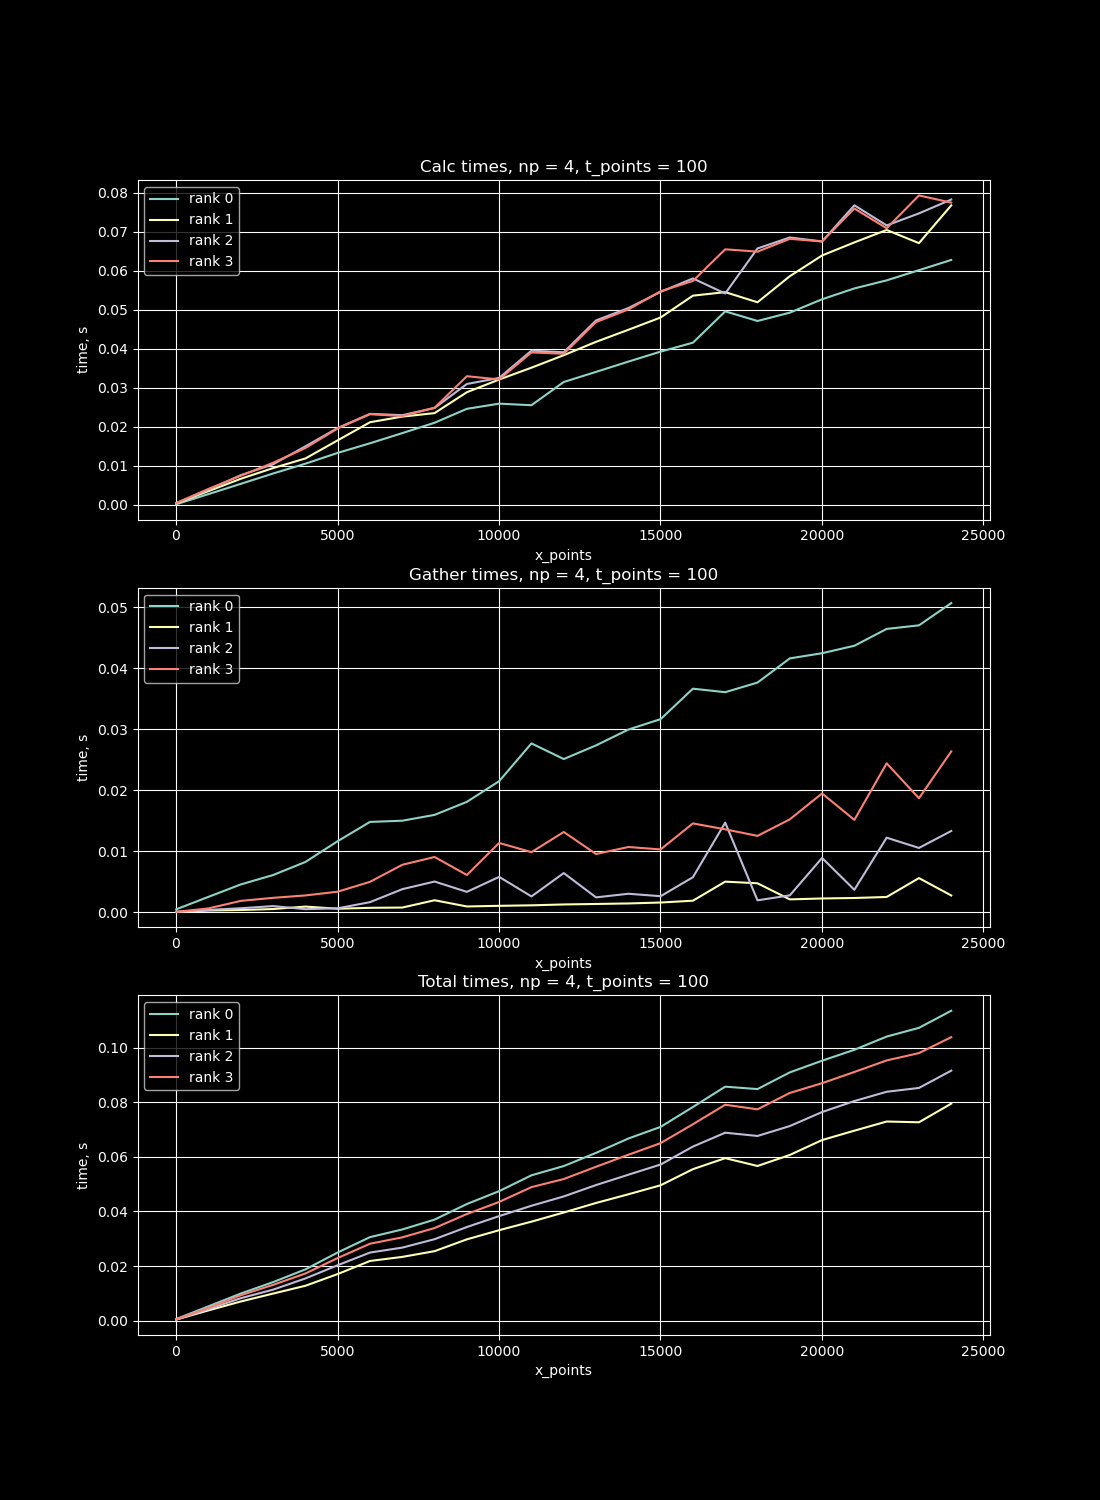

In [146]:
### x_points var at cluster

x_points_var = np.zeros (int ((x_points_end - x_points_start) / x_var_step) + 1)
times = np.zeros ((3, n_proc, int ((x_points_end - x_points_start) / x_var_step) + 1))
i = x_points_start
k = 0
tabledata = []
with tqdm(total=int ((x_points_end - x_points_start) / x_var_step) + 1) as pbar:
    while i < x_points_end:
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (i), "{0}".format (t_points_at_x_var), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        #print (compile)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (2)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        #print (result)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        x_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + x_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["x_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, t_points = {1}".format(n_proc, t_points_at_x_var))
plt.xlabel ("x_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (x_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 25/25 [02:30<00:00,  6.04s/it]

  t_points    max calc time    max gather time    max total time
----------  ---------------  -----------------  ----------------
        10      0.000282049        0.000344038       0.000513077
      1010      0.00656009         0.00375891        0.00805998
      2010      0.0213749          0.0149879         0.023428
      3010      0.033957           0.0250289         0.0368881
      4010      0.0507951          0.0369599         0.053792
      5010      0.063601           0.047302          0.0684199
      6010      0.0801179          0.059921          0.0851321
      7010      0.096921           0.073107          0.102414
      8010      0.0958769          0.0700629         0.102107
      9010      0.123641           0.0933371         0.130996
     10010      0.140868           0.106149          0.148702
     11010      0.150398           0.115431          0.159331
     12010      0.158785           0.121113          0.168808
     13010      0.180981           0.13675           0.1

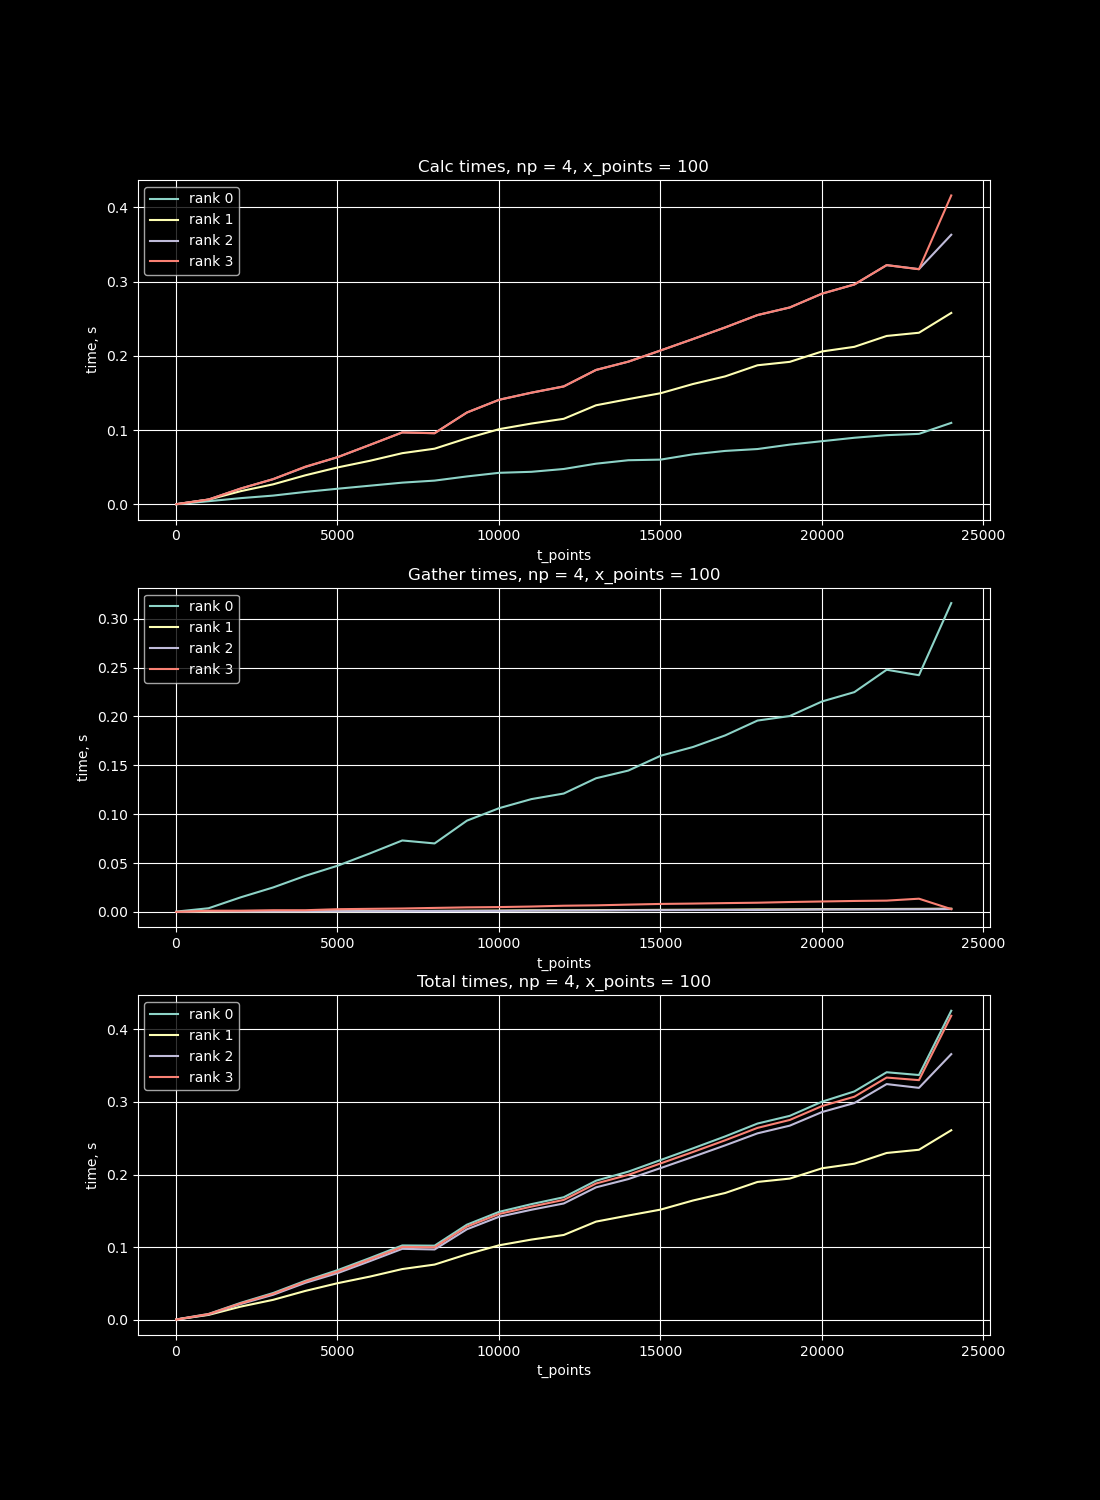

In [147]:
### t_points var at cluster

t_points_var = np.zeros (int ((t_points_end - t_points_start) / t_var_step) + 1)
times = np.zeros ((3, n_proc, int ((t_points_end - t_points_start) / t_var_step) + 1))
i = t_points_start
k = 0
tabledata = []
with tqdm(total=int ((t_points_end - t_points_start) / t_var_step) + 1) as pbar:
    while i < t_points_end:
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (n_proc), "ARGS=\"", "{0}".format (x_points_at_t_var), "{0}".format (i), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (2)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        times_max = np.zeros (3)
        for p in range (0, n_proc):
            rank = int (res_split[p * 4])
            for j in range (0, 3):
                times[j][rank][k] = res_split[p * 4 + j + 1]
                if times[j][rank][k] > times_max[j]:
                    times_max[j] = times[j][rank][k]
        t_points_var[k] = i
        temp = []
        temp.append (i)
        temp.append (times_max[0])
        temp.append (times_max[1])
        temp.append (times_max[2])
        tabledata.append (temp)
        i = i + t_var_step
        k = k + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["t_points", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 15])

plt.subplot (311)
plt.grid ()
plt.title ("Calc times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[0][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (312)
plt.grid ()
plt.title ("Gather times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[1][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

plt.subplot (313)
plt.grid ()
plt.title ("Total times, np = {0}, x_points = {1}".format(n_proc, x_points_at_t_var))
plt.xlabel ("t_points")
plt.ylabel ("time, s")
for i in range(0, n_proc):
    plt.plot (t_points_var, times[2][i], 'C{0}'.format (i), label = 'rank {0}'.format(i))
plt.legend ()

100%|██████████| 16/16 [03:10<00:00, 11.89s/it]

  N proc    max calc time    max gather time    max total time
--------  ---------------  -----------------  ----------------
       1         2.15079            0                  2.15083
       2         1.94212            1.12582            2.10425
       3         1.37032            0.979814           1.59299
       4         0.982759           0.775388           1.21844
       5         1.30199            1.18031            1.52102
       6         1.33592            1.26883            1.54367
       7         1.61248            1.53915            1.74298
       8         1.38917            1.42792            1.63661
       9         1.20724            1.2363             1.42423
      10         0.835033           0.942569           1.22249
      11         1.61617            1.69365            1.84661
      12         1.65276            1.75585            1.89826
      13         0.751653           1.08658            1.57998
      14         1.27527            1.41161            

<StemContainer object of 3 artists>

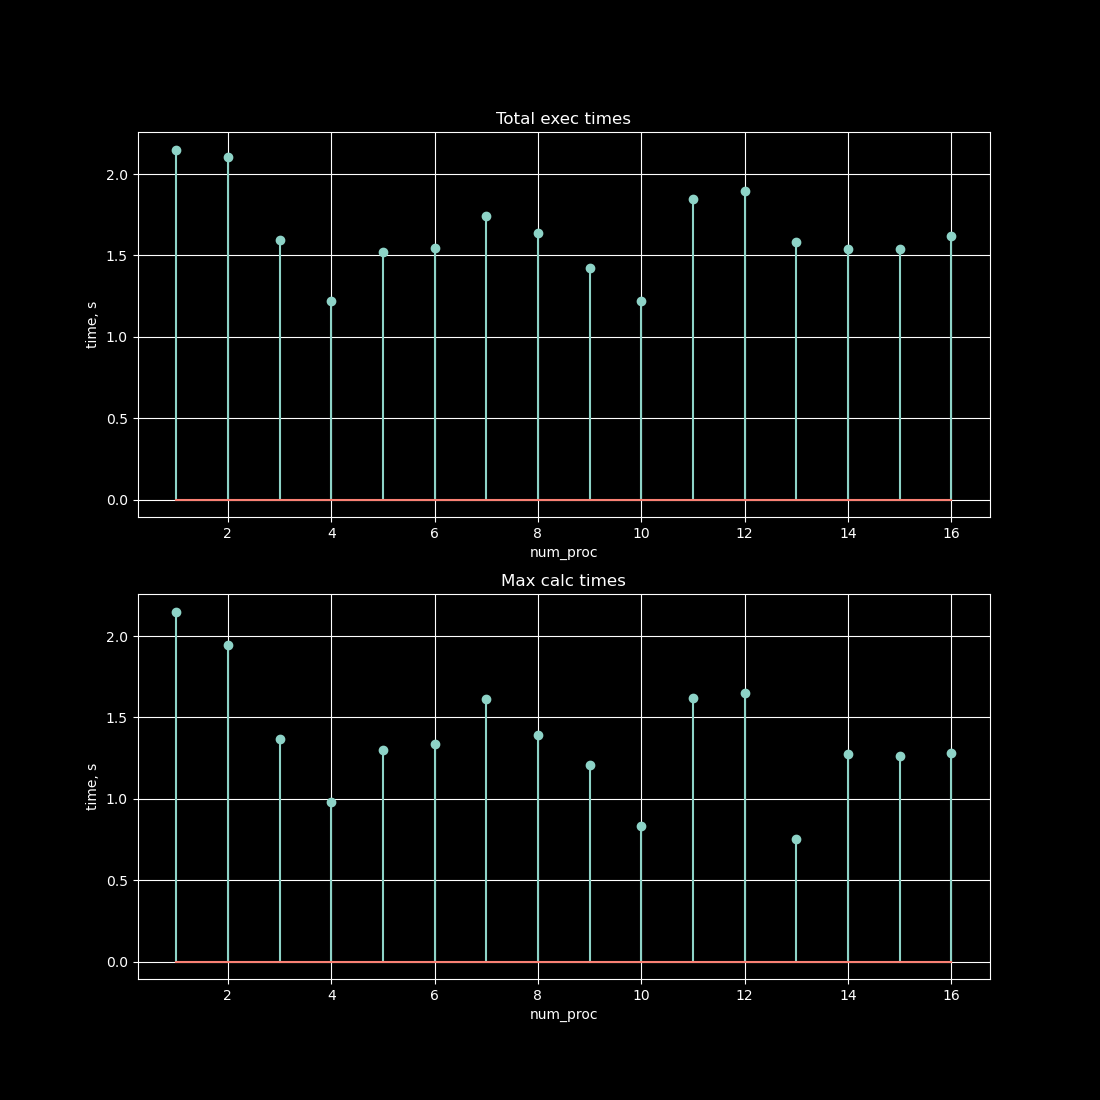

In [148]:
### np var at cluster
np_end = 16
np_var = np.arange (np_start, np_end + 1)
times = np.zeros ((3, np_end - np_start + 1))
i = np_start
tabledata = []
with tqdm(total = np_end - np_start + 1) as pbar:
    while i <= np_end: 
        compile = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "NUM_PROC={0}".format (i), "ARGS=\"", "{0}".format (x_points_at_np_var), "{0}".format (t_points_at_np_var), "{0}".format (x_max), "{0}".format (t_max), "n\"", "-C", "./lab1/"], capture_output=True)
        time.sleep (2)
        run = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "make", "-C", "./lab1/", "run"], capture_output=True)
        time.sleep (6)
        result = subprocess.run (["sshpass", "-p", "omeunzimarod", "ssh", "-o StrictHostKeyChecking=no", "-p", "52960", "b0190302@remote.vdi.mipt.ru", "cat", "./lab1/stdout.txt"], capture_output=True, text=True)
        res_split = result.stdout.split ()
        max_calc = 0
        max_gather = 0
        max_total = 0
        for p in range (0, i - np_start + 1):
            if float (res_split[p * 4 + 1]) > max_calc:
                max_calc = float (res_split[p * 4 + 1])
            if float (res_split[p * 4 + 2]) > max_gather:
                max_gather = float (res_split[p * 4 + 2])
            if float (res_split[p * 4 + 3]) > max_total:
                max_total = float (res_split[p * 4 + 3])

        times[0][i - np_start] = max_calc
        times[1][i - np_start] = max_gather
        times[2][i - np_start] = max_total
        temp = []
        temp.append (i)
        temp.append (max_calc)
        temp.append (max_gather)
        temp.append (max_total)
        tabledata.append (temp)
        i = i + 1
        pbar.update (1)

print (tabulate (tabledata, headers = ["N proc", "max calc time", "max gather time", "max total time"]))

plt.figure (figsize = [11, 11])

plt.subplot (211)
plt.grid ()
plt.title ("Total exec times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[2])

plt.subplot (212)
plt.grid ()
plt.title ("Max calc times")
plt.xlabel ("num_proc")
plt.ylabel ("time, s")
plt.stem (np_var, times[0])